# Imports and Helpers

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from einops import rearrange
import random
from matplotlib.colors import rgb2hex
from tqdm.notebook import tqdm
import os
import copy
import sys
print(sys.version)
import pandas as pd

%matplotlib inline
# %matplotlib ipympl

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


## Helper funcs

In [185]:
def rearrange_sample(house):
    # this rearranges the training sample into an x y z m shape
    world = rearrange(house, 'z y x b -> x y z b')
    return world

In [186]:
def trim_world_empty(world):
    # this removes empty voxels sorrounding a world
    arr_slices = tuple(np.s_[curr_arr.min():curr_arr.max() + 1] for curr_arr in world[:,:,:,0].nonzero())
    return world[arr_slices]

In [187]:
def pad_world(world):
    # this pads a world to the smallest cubic volume that it can fit in
    (x, y, z, m) = world.shape
    min_dim = max(world.shape[0:3])
    world = np.pad(world, ((0, min_dim - x),(0, min_dim - y),(0, min_dim - z), (0, 0)), 'constant')
    return world
def something():
    return "hi"

## Load some houses

In [188]:
# Explore directory
DATA_DIR = "house_data/houses"
HOUSES_DIRS = [o for o in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR,o,"schematic.npy"))]
print("Num suable houses in dir:", len(HOUSES_DIRS))

Num suable houses in dir: 2532


In [189]:
# an array for some sample examples
selected_houses_dirs = ["workdir.2018-06-22-16:39:03.ip-172-31-9-250", # match box
    "workdir.2018-06-23-07:16:40.ip-172-31-5-36", # a house with deck
    "workdir.2018-06-22-20:45:54.ip-172-31-2-250", # quartz house
    "workdir.2018-06-23-08:09:44.ip-172-31-10-251", # tree house
    "workdir.2018-06-22-19:13:10.ip-172-31-13-79", # normal hut
    "workdir.2018-06-23-18:11:04.ip-172-31-0-19", # normal hut
]

houses_sample_size = 20
sample_houses_dirs = random.sample(HOUSES_DIRS, houses_sample_size)

sample_houses, selected_houses = pd.DataFrame(), pd.DataFrame()
for dir in sample_houses_dirs:
    sample_houses = sample_houses.append({
        'world': pad_world(trim_world_empty(rearrange_sample(np.load(DATA_DIR + "/" + dir + "/schematic.npy")))),
        'dir': dir
    }, ignore_index=True)
    
for dir in selected_houses_dirs:
    selected_houses = selected_houses.append({
        'world': pad_world(trim_world_empty(rearrange_sample(np.load(DATA_DIR + "/" + dir + "/schematic.npy")))),
        'dir': dir
    }, ignore_index=True)
    
print("selected", len(selected_houses_dirs), "houses") # the number of houses loaded
print("sampled", len(sample_houses), "houses") # the number of houses loaded

selected 6 houses
sampled 20 houses


In [190]:
print(selected_houses['dir'][0])
print(selected_houses['world'][0].shape)
print(sample_houses['dir'][0])
print(sample_houses['world'][0].shape)

workdir.2018-06-22-16:39:03.ip-172-31-9-250
(13, 13, 13, 2)
workdir.2018-08-12-00:09:11.ip-172-31-9-243
(18, 18, 18, 2)


# Visualiser

In [191]:
def get_color_dict(unique_vals):
    state = np.random.RandomState(0)
    color_arr = list(state.uniform(0, 1, (len(unique_vals), 3)))
    color_arr = [rgb2hex(color) for color in color_arr]
    color_arr = [None] + color_arr # set all to 0 for air block (block id 0)
    colors = color_arr[: len(unique_vals)] # chop off the last random
    color_dict = {str(unique_vals[i]): colors[i] for i in range(len(unique_vals))} # make string
    return color_dict # return

print("sample colour dict:", get_color_dict(np.array([2,3,4])))

sample colour dict: {'2': None, '3': '#8cb69a', '4': '#8b6ca5'}


In [192]:
def convert_to_color(arr, color_dict):
    new_arr = copy.deepcopy(arr).astype(object)
    for k in color_dict:
        new_arr[new_arr == int(k)] = color_dict[k]
    return new_arr

In [193]:
def visualise_world(worlds, plots_per_row = 4, figsize = (20, 20)):
    
    try:
        _ = worlds[0][0][0][0][0]
    except IndexError:
        worlds = [worlds] 

    fig, axs = plt.subplots(math.ceil(len(worlds)/plots_per_row), plots_per_row, figsize = figsize, subplot_kw={"projection": '3d', "adjustable": 'box'})
    
    try:
        _ = axs[0][0]
    except:
        axs = [axs] 
        
    r, c = 0, 0
    for world in tqdm(worlds):

        (x, y, z, b) = world.shape
        blockidarray, blockmetaarray = world[:,:,:,0], world[:,:,:,1]

        color_dict = get_color_dict(np.unique(blockidarray))
        colors = convert_to_color(blockidarray, color_dict)
        
        meta_color_dict = get_color_dict(np.unique(blockmetaarray))
        edge_colors = convert_to_color(blockmetaarray, meta_color_dict)
        
        axs[r][c].title.set_text('This should be a house')
        axs[r][c].voxels(blockidarray, facecolors=colors, edgecolors=edge_colors)
        c += 1
        if c == plots_per_row:
            c = 0
            r += 1

    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

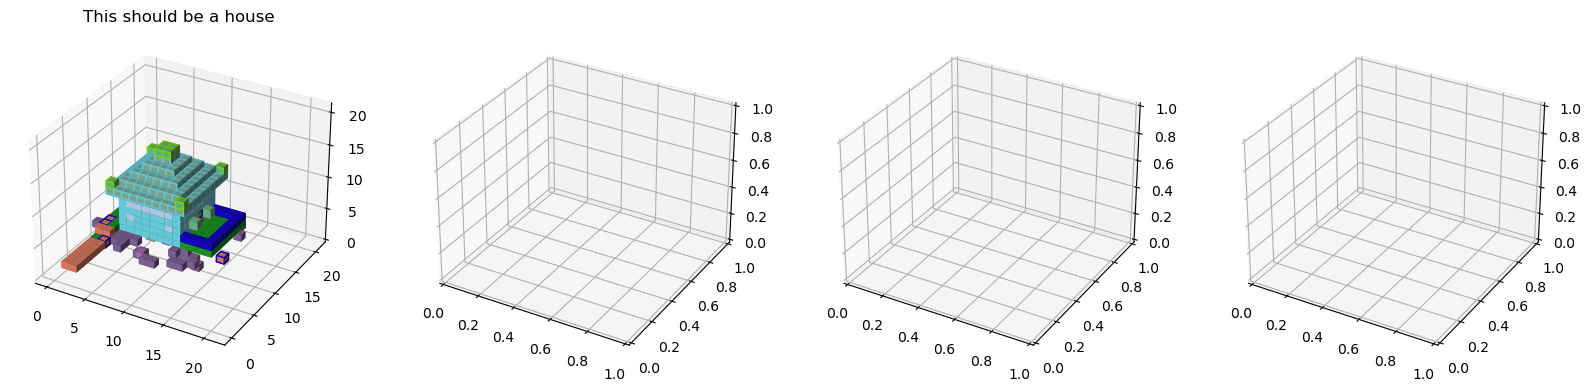

In [194]:
plt.style.use(['default'])
visualise_world(selected_houses['world'][1])

  0%|          | 0/20 [00:00<?, ?it/s]

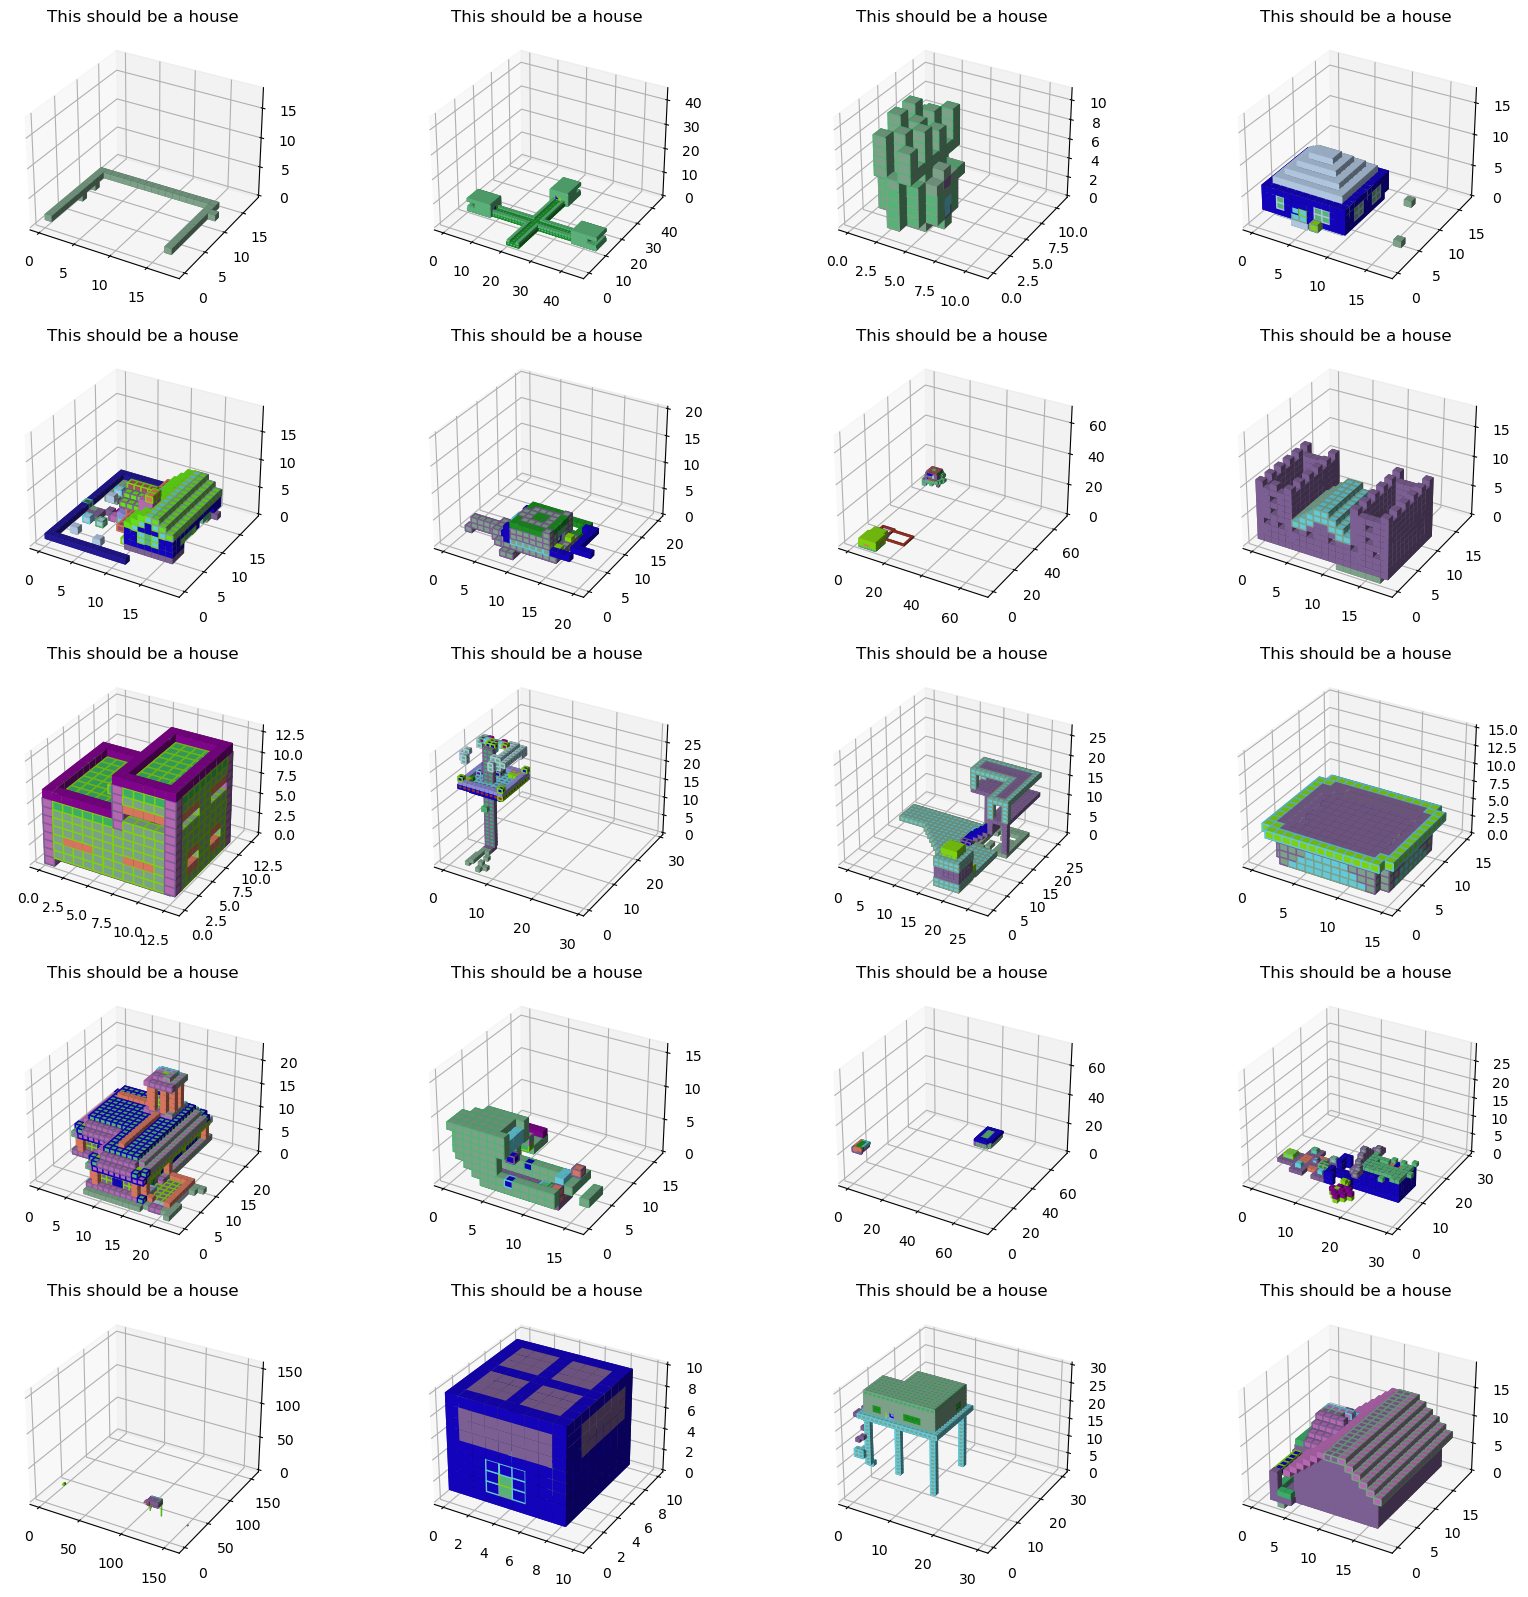

In [196]:
visualise_world(sample_houses['world'])

# Overview stats

- num unique block distribution (exclude meta)
- num unique block distribution (include meta)
- trimmed cube size distribution

While the original paper (cite) provides statistics on, e.g. block types and number of blocks in each house, it's not useful when it comes to selecting usable training examples for the model. 

We run python code to calculate the smallest cuboid box that the training example can fit in.

In [200]:
# load all houses

example_houses_df = pd.DataFrame()
for dir in tqdm(HOUSES_DIRS):
    try:
        example_houses_df = example_houses_df.append({
            'world': pad_world(trim_world_empty(rearrange_sample(np.load(DATA_DIR + "/" + dir + "/schematic.npy")))),
            'dir': dir
        }, ignore_index=True)
    except:
        print(dir)

print('loaded', len(example_houses_df), 'houses')

  0%|          | 0/2532 [00:00<?, ?it/s]

loaded 2532 houses


In [231]:
import seaborn as sns
import pandas as pd
sns.set_theme()
tqdm.pandas()
sns.set_style("dark")
import time
import timeout_decorator

In [262]:
load_world_timeout = 10 # seconds

@timeout_decorator.timeout(load_world_timeout, timeout_exception=TimeoutError) 
def world_summary_data(world): 
    (x, _, _, _) = world.shape
    blockidarray = world[:,:,:,0]
    blockmetaarray = world[:,:,:,1]
    trimmedidarray = trim_world_empty(world)[:,:,:,0]
    
    # get size
    size = x

    # get unique block ids
    unique_ids = np.unique(blockidarray)
    nums_id_types = len(unique_ids)
    
    # get unique blocks variations
    block_list = rearrange(world, 'x y z m -> (x y z) m')
    nums_unique_types = len(np.unique(block_list, axis=0))
    
    # get air block percentage
    id_list = block_list[:,0]
    percentages_air = np.sum(np.equal(id_list, 0)) / len(id_list)
    
    # get air block percentage
    trimmed_id_list = rearrange(trimmedidarray, 'x y z -> (x y z)')
    trimmed_percentages_air = np.sum(np.equal(trimmed_id_list, 0)) / len(trimmed_id_list)
    
    return size, nums_id_types, nums_unique_types, percentages_air, trimmed_percentages_air

In [279]:
stats_df = pd.DataFrame()

timeout_dirs = []

for i, row in tqdm(example_houses_df.iterrows(), total=example_houses_df.shape[0]):
    timeout_start = time.time()
    
    world = row['world']
    
    try: 
        size, nums_id_types, nums_unique_types, percentages_air, trimmed_percentages_air = world_summary_data(world)
    except TimeoutError:
        print("timeout loading: '{}'".format(row['dir']))
        timeout_dirs += [(row['dir'])]
        continue
    
    # check world
    # if size > 128:
        # print("!!! so big of a world!")
        # print("at", i, "size", x)

    # add to df
    stats_df = stats_df.append({
        'Size': size,
        'Num unique IDs': nums_id_types,
        'Num unique blocks': nums_unique_types,
        'Percentage air untrimmed': percentages_air,
        'Percentage air trimmed': trimmed_percentages_air,
    }, ignore_index=True)
    
print('calculated stats for', len(stats_df), 'houses')

  0%|          | 0/2532 [00:00<?, ?it/s]

timeout loading: 'workdir.2018-08-25-01:51:28.ip-172-31-9-19'
timeout loading: 'workdir.2018-08-21-17:51:55.ip-172-31-9-147'
timeout loading: 'workdir.2018-08-05-20:35:42.ip-172-31-10-105'
timeout loading: 'workdir.2018-08-14-02:57:12.ip-172-31-4-64'
timeout loading: 'workdir.2018-08-19-02:41:28.ip-172-31-4-60'
timeout loading: 'workdir.2018-07-31-00:21:12.ip-172-31-10-166'
timeout loading: 'workdir.2018-08-02-01:48:55.ip-172-31-14-200'
timeout loading: 'workdir.2018-08-21-07:00:18.ip-172-31-7-194'
timeout loading: 'workdir.2018-08-23-00:04:03.ip-172-31-11-156'
timeout loading: 'workdir.2018-08-18-04:17:27.ip-172-31-9-98'
timeout loading: 'workdir.2018-08-05-21:44:47.ip-172-31-5-95'
timeout loading: 'workdir.2018-08-22-21:52:38.ip-172-31-10-113'
timeout loading: 'workdir.2018-08-25-16:54:11.ip-172-31-7-170'
timeout loading: 'workdir.2018-06-22-23:01:46.ip-172-31-15-114'
timeout loading: 'workdir.2018-08-17-05:07:45.ip-172-31-4-201'
timeout loading: 'workdir.2018-08-14-01:39:16.ip-172-3

In [273]:
# save
# stats_df.to_pickle("data_stats_without_timeout.pkl")

In [ ]:
# load
stats_df = pd.read_pickle("data_stats_without_timeout.pkl")

## Deal with timeout

In [281]:
# save timeout list
timeout_df = pd.DataFrame({'timeout dir': timeout_dirs})
timeout_df.to_pickle("timeout_dirs.pkl")

In [282]:
# load
timeout_df = pd.read_pickle("timeout_dirs.pkl")

In [284]:
list(timeout_df['timeout dir'])

['workdir.2018-08-25-01:51:28.ip-172-31-9-19',
 'workdir.2018-08-21-17:51:55.ip-172-31-9-147',
 'workdir.2018-08-05-20:35:42.ip-172-31-10-105',
 'workdir.2018-08-14-02:57:12.ip-172-31-4-64',
 'workdir.2018-08-19-02:41:28.ip-172-31-4-60',
 'workdir.2018-07-31-00:21:12.ip-172-31-10-166',
 'workdir.2018-08-02-01:48:55.ip-172-31-14-200',
 'workdir.2018-08-21-07:00:18.ip-172-31-7-194',
 'workdir.2018-08-23-00:04:03.ip-172-31-11-156',
 'workdir.2018-08-18-04:17:27.ip-172-31-9-98',
 'workdir.2018-08-05-21:44:47.ip-172-31-5-95',
 'workdir.2018-08-22-21:52:38.ip-172-31-10-113',
 'workdir.2018-08-25-16:54:11.ip-172-31-7-170',
 'workdir.2018-06-22-23:01:46.ip-172-31-15-114',
 'workdir.2018-08-17-05:07:45.ip-172-31-4-201',
 'workdir.2018-08-14-01:39:16.ip-172-31-11-213',
 'workdir.2018-06-27-00:42:02.ip-172-31-7-98',
 'workdir.2018-08-15-02:16:13.ip-172-31-15-183']

In [295]:
err_id = example_houses['dir'][example_houses['dir'] == 'workdir.2018-08-25-01:51:28.ip-172-31-9-19'].index.tolist()[0]
err_id

501

In [303]:
err_world = example_houses.loc[err_id]['world']
err_world.shape

(406, 406, 406, 2)

In [305]:
(x, _, _, _) = err_world.shape
blockidarray = err_world[:,:,:,0]
blockmetaarray = err_world[:,:,:,1]
trimmedidarray = trim_world_empty(err_world)[:,:,:,0]

# get size
size = x

# get unique block ids
unique_ids = np.unique(blockidarray)
nums_id_types = len(unique_ids)

# get unique blocks variations
block_list = rearrange(err_world, 'x y z m -> (x y z) m')
nums_unique_types = len(np.unique(block_list, axis=0))

# get air block percentage
id_list = block_list[:,0]
percentages_air = np.sum(np.equal(id_list, 0)) / len(id_list)

# get air block percentage
trimmed_id_list = rearrange(trimmedidarray, 'x y z -> (x y z)')
trimmed_percentages_air = np.sum(np.equal(trimmed_id_list, 0)) / len(trimmed_id_list)

  0%|          | 0/1 [00:00<?, ?it/s]

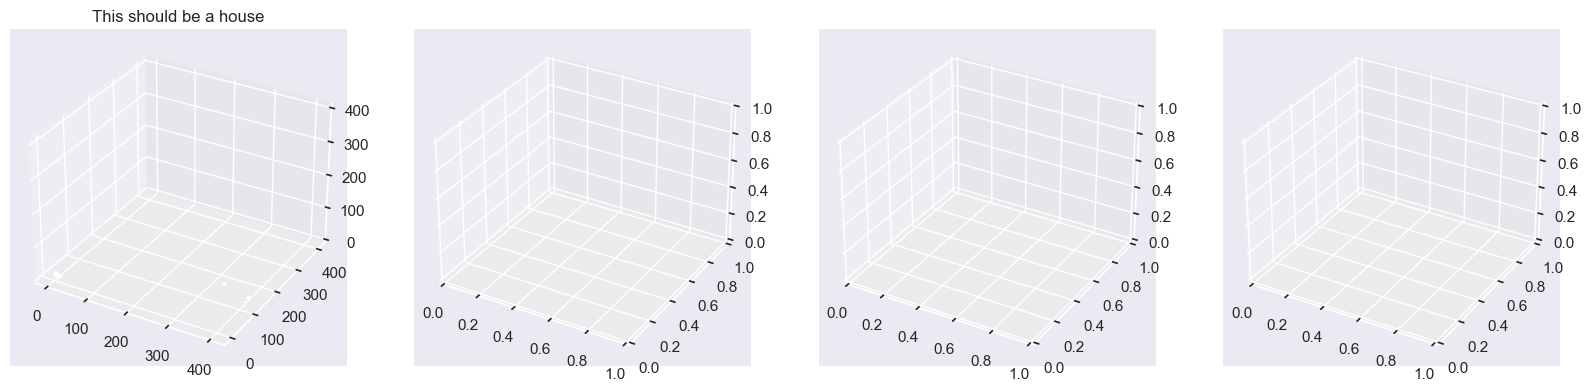

In [ ]:
visualise_world(err_world)

## Graphing

### World sizes
While the original paper (cite) provides statistics on, e.g. block types and number of blocks in each house, it's not useful when it comes to selecting usable training examples for the model. 

We run python code to calculate the smallest cuboid box that the training example can fit in.

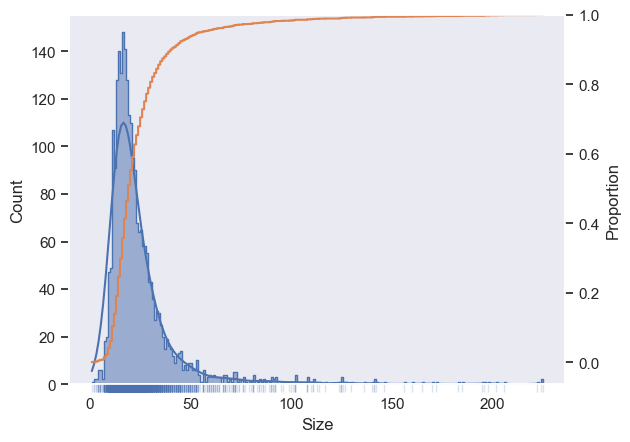

In [ ]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Size', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Size", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Size", stat="proportion")

plt.show()

### Block types

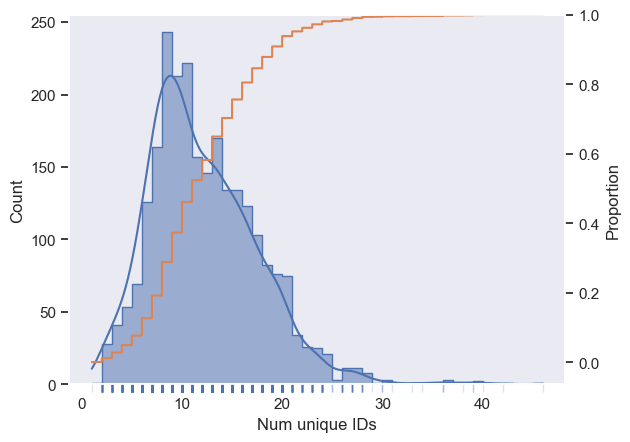

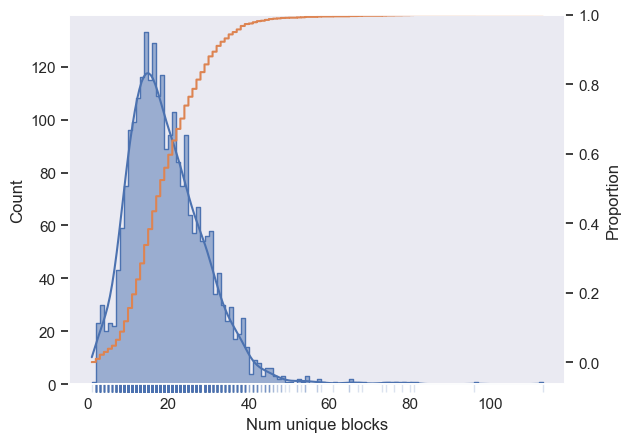

In [ ]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Num unique IDs', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Num unique IDs", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Num unique IDs", stat="proportion")

plt.show()

plt.figure()
ax = sns.histplot(data=stats_df, x='Num unique blocks', kde=True, binwidth=1, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Num unique blocks", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Num unique blocks", stat="proportion")

plt.show()

(-8.45, 50.95, -22.519999999999996, 125.32)

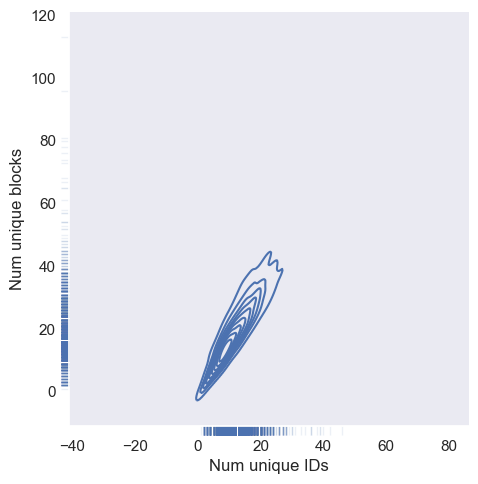

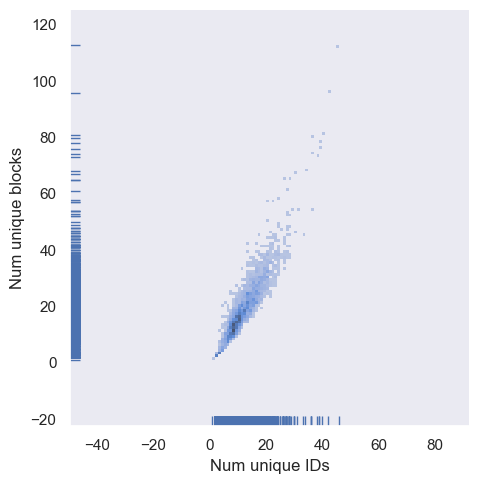

In [ ]:
# block types 2d
sns.displot(data=stats_df, x='Num unique IDs', y='Num unique blocks', kind="kde", rug=True, rug_kws={'height': -0.02, 'alpha': .1, 'clip_on': False})
plt.axis('equal')
sns.displot(data=stats_df, x='Num unique IDs', y='Num unique blocks', kind="hist", rug=True, binwidth=1)
plt.axis('equal')

### Air blocks

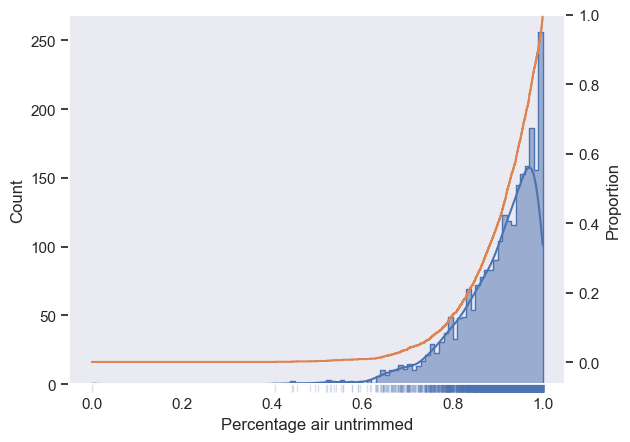

In [ ]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Percentage air untrimmed', kde=True, binwidth=0.01, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Percentage air untrimmed", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Percentage air untrimmed", stat="proportion")

plt.show()

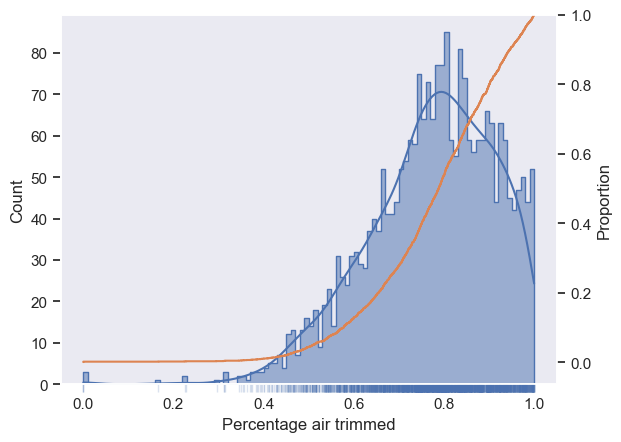

In [ ]:
plt.figure()
ax = sns.histplot(data=stats_df, x='Percentage air trimmed', kde=True, binwidth=0.01, element="step")
ax2 = ax.twinx()
sns.rugplot(data=stats_df, x="Percentage air trimmed", height=-0.02, alpha=.2, clip_on=False)
sns.ecdfplot(data=stats_df, x="Percentage air trimmed", stat="proportion")

plt.show()

## Cleaning data

The Craft-3D dataset contains several outlying training examples that are too large to be processed in reasonable time. In our experiment, a total of 18 such examples failed to be loaded after 10 seconds of timeout and were ignored. 

Prelimilary data exploration suggests that the house size is heavily right-skewed (see fig. _). To select a subset suitable for our model architecture, we removed training example that has any dimension larger than 64.

Data exploration also shows that there exist many training examples with an unreasonable proportion of air blocks (see fig. _). To make sure that only reasonable houses are fed to the discriminator, we only include training examples with block percentage greater than 4%

Seeing that some training examples have very limited variety of block types or overwhelming diverse block types, we select training examples with number of block ids in the range [_, _] and unique block types in the range [, ].

In [ ]:
# some code to clean data

The data selection procedure led to a subset of _ valid training examples in the original set of _ houses.